In [1]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import torch

# %matplotlib inline

In [2]:
csv_fp = "/home/shuowang/data/aod_pm25/mGCNNData5km_with_unique_ID.csv"

In [3]:
# Read cvs file
df = pd.read_csv(csv_fp)

In [4]:
df

,LON,LAT,ID,ROW,COL,YEAR,MONTH,DAY,HOUR,AOD,...,U10,V10,BLH,TP,E,RH,TCW,O,PM2.5,UNIQUE-ID
0,124.15,50.40,89063,72,1023,2019,1,30,4,0.24890,...,5.5053,-3.7982,1342.50,0.000005,-2.970000e-05,52.878,1.5364,0.010632,29,26
1,124.15,50.40,89063,72,1023,2019,1,30,4,0.24890,...,5.5053,-3.7982,1342.50,0.000005,-2.970000e-05,52.878,1.5364,0.010632,29,0
2,127.45,50.25,92849,75,1089,2019,1,30,4,0.19261,...,4.8472,-3.5446,1201.80,0.000076,-2.010000e-05,54.191,2.2369,0.010732,23,1
3,127.50,50.20,94090,76,1090,2019,1,30,4,0.16980,...,4.8861,-3.5129,1204.00,0.000077,-2.190000e-05,54.270,2.2534,0.010741,26,2
4,127.55,50.20,94091,76,1091,2019,1,30,4,0.16449,...,4.9303,-3.4814,1190.60,0.000080,-2.240000e-05,54.812,2.2635,0.010742,16,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435238,110.30,20.00,843000,680,746,2019,2,12,15,0.17037,...,-1.4422,-1.7423,56.78,0.000000,2.680000e-07,97.047,2.2943,0.009206,13,1149
435239,110.35,20.00,843000,680,747,2019,2,12,15,0.16847,...,-1.4422,-1.7423,56.78,0.000000,2.680000e-07,96.884,2.2943,0.009206,10,1150
435240,110.35,19.95,844000,681,747,2019,2,12,15,0.17088,...,-1.4422,-1.7423,56.78,0.000000,2.680000e-07,97.211,2.2943,0.009206,12,1151
435241,110.60,19.95,844000,681,752,2019,2,12,15,0.26282,...,-1.4422,-1.7423,56.78,0.000000,2.680000e-07,96.544,2.2943,0.009206,9,1152


In [5]:
# Get UNIQUE-ID's longitude and latitude
unique_id = df["UNIQUE-ID"].unique()
unique_id = unique_id[~np.isnan(unique_id)]
unique_id = unique_id.astype(int)

# Get longitude and latitude of all UNIQUE-ID's
df_unique_id = df.loc[df["UNIQUE-ID"].isin(unique_id)]
df_unique_id = df_unique_id[["UNIQUE-ID", "LON", "LAT"]]
df_unique_id = df_unique_id.drop_duplicates()
df_unique_id = df_unique_id.sort_values(by=["UNIQUE-ID"])
df_unique_id = df_unique_id.reset_index(drop=True)

ids = df_unique_id["UNIQUE-ID"].values

df_unique_id

,UNIQUE-ID,LON,LAT
0,0,124.15,50.40
1,1,127.45,50.25
2,2,127.50,50.20
3,3,127.55,50.20
4,4,119.80,49.20
...,...,...,...
1171,1170,115.45,35.20
1172,1171,119.55,26.65
1173,1172,118.65,24.95
1174,1173,118.20,24.45


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
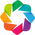

:Overlay
   .Points.I :Points   [LON,LAT]   (UNIQUE-ID)
   .WMTS.I   :WMTS   [Longitude,Latitude]

In [6]:
# Plot longitude and latitude of all UNIQUE-ID's using geoviews
import geoviews as gv
import geoviews.feature as gf
import geoviews.tile_sources as gts
from cartopy import crs
from geoviews import opts

gv.extension("bokeh")

# Create a dataframe for plotting
df_plot = df_unique_id.copy()
df_plot["LON"] = df_plot["LON"].astype(float)
df_plot["LAT"] = df_plot["LAT"].astype(float)
df_plot["UNIQUE-ID"] = df_plot["UNIQUE-ID"].astype(str)
df_plot["UNIQUE-ID"] = df_plot["UNIQUE-ID"].astype(float)

# Create a geoviews dataset
ds = gv.Dataset(df_plot, kdims=["LON", "LAT"], vdims=["UNIQUE-ID"])

# Create a geoviews plot
plot = gv.Points(ds, vdims=["UNIQUE-ID"]).opts(
    opts.Points(
        color="UNIQUE-ID",
        cmap="viridis",
        size=2,
        tools=["hover"],
        width=600,
        height=400,
        colorbar=False,
        toolbar="above",
        xaxis=None,
        yaxis=None,
    )
)

# Create a geoviews plot with a map
plot * gts.CartoLight


In [7]:
# 合并 YEAR, MONTH, DAY, HOUR 列为 datetime 列
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY', 'HOUR']])

# 显示前几行数据以确认 datetime 列已正确添加
print(df.head())

      LON    LAT     ID  ROW   COL  YEAR  MONTH  DAY  HOUR      AOD  ...  \
0  124.15  50.40  89063   72  1023  2019      1   30     4  0.24890  ...   
1  124.15  50.40  89063   72  1023  2019      1   30     4  0.24890  ...   
2  127.45  50.25  92849   75  1089  2019      1   30     4  0.19261  ...   
3  127.50  50.20  94090   76  1090  2019      1   30     4  0.16980  ...   
4  127.55  50.20  94091   76  1091  2019      1   30     4  0.16449  ...   

      V10     BLH        TP         E      RH     TCW         O  PM2.5  \
0 -3.7982  1342.5  0.000005 -0.000030  52.878  1.5364  0.010632     29   
1 -3.7982  1342.5  0.000005 -0.000030  52.878  1.5364  0.010632     29   
2 -3.5446  1201.8  0.000076 -0.000020  54.191  2.2369  0.010732     23   
3 -3.5129  1204.0  0.000077 -0.000022  54.270  2.2534  0.010741     26   
4 -3.4814  1190.6  0.000080 -0.000022  54.812  2.2635  0.010742     16   

   UNIQUE-ID                DATE  
0         26 2019-01-30 04:00:00  
1          0 2019-01-30 04:0

In [8]:
print(df.columns.tolist())

['LON', 'LAT', 'ID', 'ROW', 'COL', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'AOD', 'NO2', 'STRM', 'LANDUC', 'NDVI', 'T', 'D', 'SP', 'U10', 'V10', 'BLH', 'TP', 'E', 'RH', 'TCW', 'O', 'PM2.5', 'UNIQUE-ID', 'DATE']


In [9]:
# 按 UNIQUE-ID 分组，并获取每个组的时序数据
grouped_data = df.groupby('UNIQUE-ID').apply(lambda x: x.sort_values('DATE'))

# 显示分组后的数据
print(grouped_data)

                     LON   LAT      ID  ROW   COL  YEAR  MONTH  DAY  HOUR  \
UNIQUE-ID                                                                   
0         1       124.15  50.4   89063   72  1023  2019      1   30     4   
          1474    124.15  50.4   89063   72  1023  2019      1   30     5   
          1475    124.15  50.4   89063   72  1023  2019      1   30     5   
          2946    124.15  50.4   89063   72  1023  2019      1   30     6   
          2947    124.15  50.4   89063   72  1023  2019      1   30     6   
...                  ...   ...     ...  ...   ...   ...    ...  ...   ...   
1174      428715  117.30  31.7  553000  446   886  2019      2   12    11   
          430180  117.30  31.7  553000  446   886  2019      2   12    12   
          431642  117.30  31.7  553000  446   886  2019      2   12    13   
          433111  117.30  31.7  553000  446   886  2019      2   12    14   
          434566  117.30  31.7  553000  446   886  2019      2   12    15   

In [10]:
ids

array([   0,    1,    2, ..., 1172, 1173, 1174])

In [11]:
# Get unique DATE's
dates = df["DATE"].unique()

# Get the max and min DATE's
date_max = dates.max()
date_min = dates.min()

full_date_range = pd.date_range(start=date_min, end=date_max, freq='H')

full_date_range

DatetimeIndex(['2019-01-30 04:00:00', '2019-01-30 05:00:00',
               '2019-01-30 06:00:00', '2019-01-30 07:00:00',
               '2019-01-30 08:00:00', '2019-01-30 09:00:00',
               '2019-01-30 10:00:00', '2019-01-30 11:00:00',
               '2019-01-30 12:00:00', '2019-01-30 13:00:00',
               ...
               '2019-02-12 06:00:00', '2019-02-12 07:00:00',
               '2019-02-12 08:00:00', '2019-02-12 09:00:00',
               '2019-02-12 10:00:00', '2019-02-12 11:00:00',
               '2019-02-12 12:00:00', '2019-02-12 13:00:00',
               '2019-02-12 14:00:00', '2019-02-12 15:00:00'],
              dtype='datetime64[ns]', length=324, freq='H')

In [12]:
for id in ids:

    # 筛选 UNIQUE-ID 为 id 的数据
    id_data = df[df['UNIQUE-ID'] == id]
    id_data.set_index('DATE', inplace=True)

    break



In [13]:
id_data

,LON,LAT,ID,ROW,COL,YEAR,MONTH,DAY,HOUR,AOD,...,U10,V10,BLH,TP,E,RH,TCW,O,PM2.5,UNIQUE-ID
DATE,,,,,,,,,,,,,,,,,,,,,
2019-01-30 04:00:00,124.15,50.4,89063,72,1023,2019,1,30,4,0.24890,...,5.50530,-3.7982,1342.50,4.680000e-06,-2.970000e-05,52.878,1.5364,0.010632,29,0
2019-01-30 05:00:00,124.15,50.4,89063,72,1023,2019,1,30,5,0.18208,...,-0.70108,-1.6298,326.29,-1.730000e-18,-1.458600e-04,46.512,7.4062,0.005373,24,0
2019-01-30 05:00:00,124.15,50.4,89063,72,1023,2019,1,30,5,0.18208,...,-0.70108,-1.6298,326.29,-1.730000e-18,-1.458600e-04,46.512,7.4062,0.005373,24,0
2019-01-30 06:00:00,124.15,50.4,89063,72,1023,2019,1,30,6,0.12972,...,-7.57920,-5.0449,1777.80,-1.730000e-18,-5.495900e-04,46.834,21.0500,0.004984,34,0
2019-01-30 06:00:00,124.15,50.4,89063,72,1023,2019,1,30,6,0.12972,...,-7.57920,-5.0449,1777.80,-1.730000e-18,-5.495900e-04,46.834,21.0500,0.004984,34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-12 13:00:00,124.15,50.4,89063,72,1023,2019,2,12,13,0.30095,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,74.365,2.2943,0.009206,11,0
2019-02-12 14:00:00,124.15,50.4,89063,72,1023,2019,2,12,14,0.31433,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,76.447,2.2943,0.009206,6,0
2019-02-12 14:00:00,124.15,50.4,89063,72,1023,2019,2,12,14,0.31433,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,76.447,2.2943,0.009206,6,0


In [14]:
# Genrete new dataframe with full date range
id_data_full_date = pd.DataFrame(index=full_date_range)

# Merge the new dataframe with the original dataframe
id_data_full_date = id_data_full_date.merge(id_data, left_index=True, right_index=True, how='left')

# Fill the missing values with nan
id_data_full_date.fillna(value=np.nan, inplace=True)

# Interpolate the missing values
id_data_full_date = id_data_full_date.interpolate()

# 如果开始的数据缺失，只能用后面的数据来填充
# Fill the missing values with the previous value
id_data_full_date.fillna(method='ffill', inplace=True)
# Fill the missing values with the next value
id_data_full_date.fillna(method='bfill', inplace=True)

id_data_full_date

,LON,LAT,ID,ROW,COL,YEAR,MONTH,DAY,HOUR,AOD,...,U10,V10,BLH,TP,E,RH,TCW,O,PM2.5,UNIQUE-ID
2019-01-30 04:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,4.0,0.24890,...,5.50530,-3.7982,1342.50,4.680000e-06,-2.970000e-05,52.878,1.5364,0.010632,29.0,0.0
2019-01-30 05:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,5.0,0.18208,...,-0.70108,-1.6298,326.29,-1.730000e-18,-1.458600e-04,46.512,7.4062,0.005373,24.0,0.0
2019-01-30 05:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,5.0,0.18208,...,-0.70108,-1.6298,326.29,-1.730000e-18,-1.458600e-04,46.512,7.4062,0.005373,24.0,0.0
2019-01-30 06:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,6.0,0.12972,...,-7.57920,-5.0449,1777.80,-1.730000e-18,-5.495900e-04,46.834,21.0500,0.004984,34.0,0.0
2019-01-30 06:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,6.0,0.12972,...,-7.57920,-5.0449,1777.80,-1.730000e-18,-5.495900e-04,46.834,21.0500,0.004984,34.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-12 13:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,2.0,12.0,13.0,0.30095,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,74.365,2.2943,0.009206,11.0,0.0
2019-02-12 14:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,2.0,12.0,14.0,0.31433,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,76.447,2.2943,0.009206,6.0,0.0
2019-02-12 14:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,2.0,12.0,14.0,0.31433,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,76.447,2.2943,0.009206,6.0,0.0
2019-02-12 15:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,2.0,12.0,15.0,0.29907,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,76.913,2.2943,0.009206,52.0,0.0


In [15]:
id_data_full_date

,LON,LAT,ID,ROW,COL,YEAR,MONTH,DAY,HOUR,AOD,...,U10,V10,BLH,TP,E,RH,TCW,O,PM2.5,UNIQUE-ID
2019-01-30 04:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,4.0,0.24890,...,5.50530,-3.7982,1342.50,4.680000e-06,-2.970000e-05,52.878,1.5364,0.010632,29.0,0.0
2019-01-30 05:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,5.0,0.18208,...,-0.70108,-1.6298,326.29,-1.730000e-18,-1.458600e-04,46.512,7.4062,0.005373,24.0,0.0
2019-01-30 05:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,5.0,0.18208,...,-0.70108,-1.6298,326.29,-1.730000e-18,-1.458600e-04,46.512,7.4062,0.005373,24.0,0.0
2019-01-30 06:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,6.0,0.12972,...,-7.57920,-5.0449,1777.80,-1.730000e-18,-5.495900e-04,46.834,21.0500,0.004984,34.0,0.0
2019-01-30 06:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,1.0,30.0,6.0,0.12972,...,-7.57920,-5.0449,1777.80,-1.730000e-18,-5.495900e-04,46.834,21.0500,0.004984,34.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-12 13:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,2.0,12.0,13.0,0.30095,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,74.365,2.2943,0.009206,11.0,0.0
2019-02-12 14:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,2.0,12.0,14.0,0.31433,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,76.447,2.2943,0.009206,6.0,0.0
2019-02-12 14:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,2.0,12.0,14.0,0.31433,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,76.447,2.2943,0.009206,6.0,0.0
2019-02-12 15:00:00,124.15,50.4,89063.0,72.0,1023.0,2019.0,2.0,12.0,15.0,0.29907,...,-1.44220,-1.7423,56.78,0.000000e+00,2.680000e-07,76.913,2.2943,0.009206,52.0,0.0


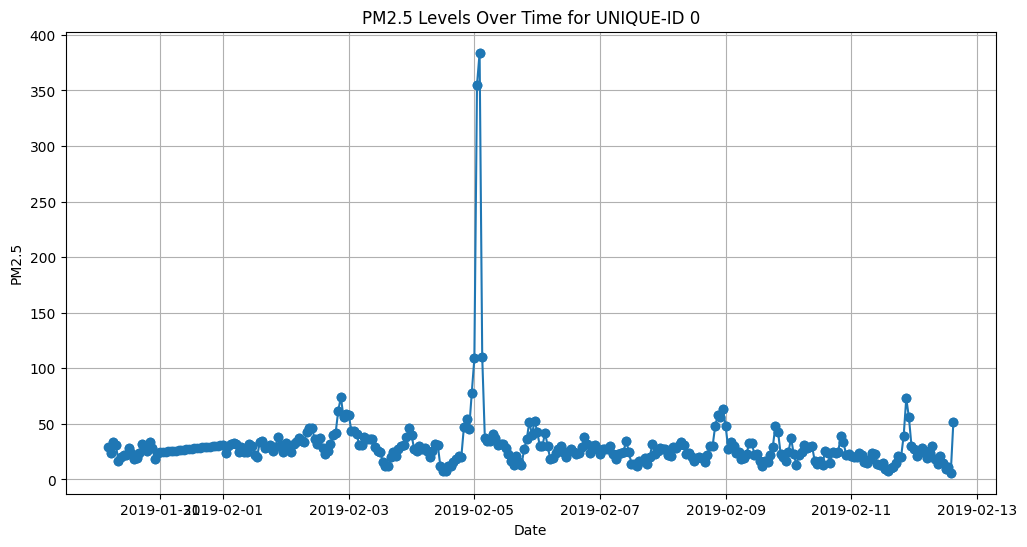

In [16]:
# 绘制 PM2.5 随时间变化的曲线图
plt.figure(figsize=(12, 6))
plt.plot(id_data_full_date.index, id_data_full_date['PM2.5'], marker='o')
plt.title('PM2.5 Levels Over Time for UNIQUE-ID 0')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.grid(True)
plt.show()

In [17]:
# 把上述插值的应用于所有的 UNIQUE-ID

for id in ids:

    # 筛选 UNIQUE-ID 为 id 的数据
    id_data = df[df['UNIQUE-ID'] == id]
    id_data.set_index('DATE', inplace=True)

    # Genrete new dataframe with full date range
    id_data_full_date = pd.DataFrame(index=full_date_range)

    # Merge the new dataframe with the original dataframe
    id_data_full_date = id_data_full_date.merge(id_data, left_index=True, right_index=True, how='left')

    # Fill the missing values with nan
    id_data_full_date.fillna(value=np.nan, inplace=True)

    # Interpolate the missing values
    id_data_full_date = id_data_full_date.interpolate()

    # 如果开始的数据缺失，只能用后面的数据来填充
    # Fill the missing values with the previous value
    id_data_full_date.fillna(method='ffill', inplace=True)
    # Fill the missing values with the next value
    id_data_full_date.fillna(method='bfill', inplace=True)

    # Save the interpolated data
    # make sure the directory exists
    interp_dir = os.path.join(os.path.dirname(csv_fp), 'interpolated_data')

    if not os.path.exists(interp_dir):
        os.makedirs(interp_dir)
    id_data_full_date.to_csv(os.path.join(interp_dir, 'UNIQUE-ID_{}.csv'.format(id)))

In [18]:
# 保存所有 UNIQUE-ID 经纬度信息

# make sure the directory exists
id_info_fp = os.path.join(os.path.dirname(csv_fp), 'id_info.csv')

df_unique_id.to_csv(id_info_fp)

In [19]:
# 读取插值后的数据, id 为 10 的数据
id_data = pd.read_csv(os.path.join(interp_dir, 'UNIQUE-ID_839.csv'), index_col=0)

id_data


,LON,LAT,ID,ROW,COL,YEAR,MONTH,DAY,HOUR,AOD,...,U10,V10,BLH,TP,E,RH,TCW,O,PM2.5,UNIQUE-ID
2019-01-30 04:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,1.0,30.0,4.0,0.37183,...,-1.5759,-0.89589,256.43,2.221400e-04,-5.180000e-05,89.270,23.2110,0.004879,79.0,839.0
2019-01-30 04:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,1.0,30.0,4.0,0.37183,...,-1.5759,-0.89589,256.43,2.221400e-04,-5.180000e-05,89.270,23.2110,0.004879,79.0,839.0
2019-01-30 05:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,1.0,30.0,5.0,0.34171,...,-7.8798,-1.07990,854.73,3.870000e-06,-1.479800e-04,88.711,23.8290,0.005216,76.0,839.0
2019-01-30 05:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,1.0,30.0,5.0,0.34171,...,-7.8798,-1.07990,854.73,3.870000e-06,-1.479800e-04,88.711,23.8290,0.005216,76.0,839.0
2019-01-30 06:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,1.0,30.0,6.0,0.32159,...,-7.5792,-5.04490,1777.80,-1.730000e-18,-5.495900e-04,91.241,21.0500,0.004984,68.0,839.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-12 13:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,2.0,12.0,13.0,0.44238,...,-1.4422,-1.74230,56.78,0.000000e+00,2.680000e-07,90.842,2.2943,0.009206,17.0,839.0
2019-02-12 14:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,2.0,12.0,14.0,0.44281,...,-1.4422,-1.74230,56.78,0.000000e+00,2.680000e-07,92.548,2.2943,0.009206,16.0,839.0
2019-02-12 14:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,2.0,12.0,14.0,0.44281,...,-1.4422,-1.74230,56.78,0.000000e+00,2.680000e-07,92.548,2.2943,0.009206,16.0,839.0
2019-02-12 15:00:00,110.5,29.1,617000.0,498.0,750.0,2019.0,2.0,12.0,15.0,0.46233,...,-1.4422,-1.74230,56.78,0.000000e+00,2.680000e-07,93.882,2.2943,0.009206,16.0,839.0


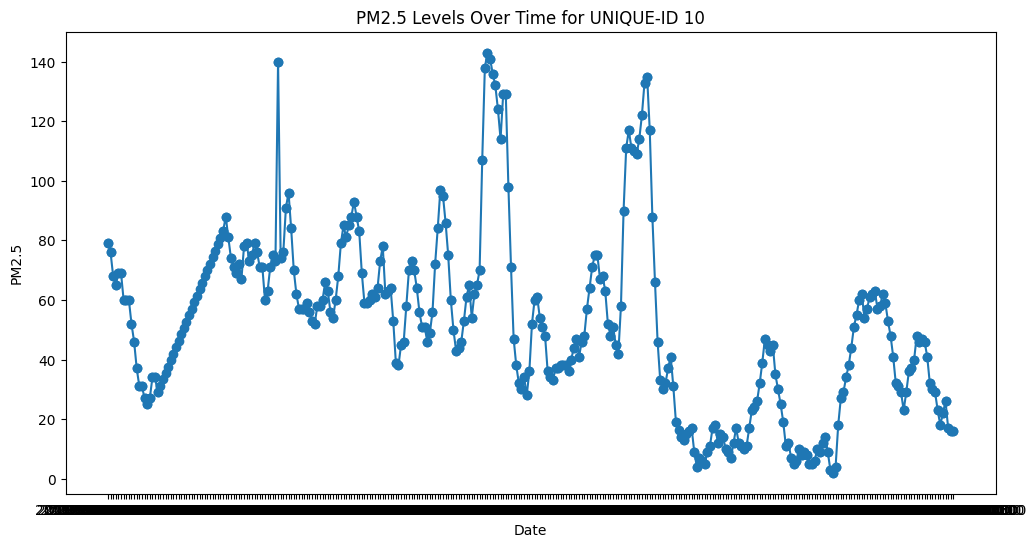

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(id_data.index, id_data['PM2.5'], marker='o')
plt.title('PM2.5 Levels Over Time for UNIQUE-ID 10')
plt.xlabel('Date')
plt.ylabel('PM2.5')
plt.show()



In [21]:
df_unique_id.iloc[1]['LON']

127.45

In [22]:
# pip install pygeodesic
from geographiclib.geodesic import Geodesic


node_num = len(df_unique_id)
dist_arr = np.zeros((node_num, node_num))
dir_arr = np.zeros((node_num, node_num))

for i in range(node_num):
    for j in range(node_num):
        geo = Geodesic.WGS84.Inverse(df_unique_id.iloc[i]['LAT'], df_unique_id.iloc[i]['LON'], df_unique_id.iloc[j]['LAT'], df_unique_id.iloc[j]['LON'])
        dist_arr[i, j] = geo['s12'] / 1000
        dir_arr[i, j] = geo['azi1']

dir_arr[dir_arr<0] = dir_arr[dir_arr < 0] + 360
np.fill_diagonal(dir_arr, 0)

dist_std = dist_arr.std()
adj = np.exp(-np.square(dist_arr / dist_std))

A, A_dist, A_dir = np.float16(adj), np.float16(dist_arr), np.float16(dir_arr)

dist_mask = A_dist > 200  # Threshold for distance
A[dist_mask] = 0
A_dist[dist_mask] = 0
A_dir[dist_mask] = 0

A_none_0 = np.unique(A)[1:]
A_min = A_none_0.min()
A_max = A_none_0.max()
A = (A - A_min) / (A_max - A_min)
A[dist_mask] = 0


In [25]:
A.max()

1.0

In [26]:
# Save the adjacency matrix to npy file
adj_fp = os.path.join(os.path.dirname(csv_fp), 'adjacency_matrix.npy')
np.save(adj_fp, A)

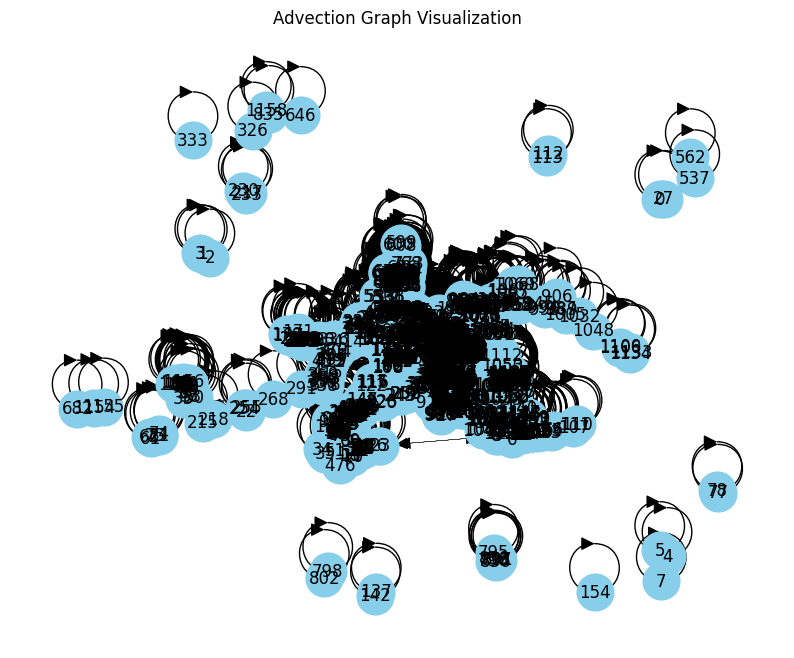

In [ ]:
G = nx.from_numpy_matrix(A, create_using=nx.DiGraph())
edge_weights = [G[u][v]["weight"] for u, v in G.edges()]

fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.spring_layout(G)  # Positioning of nodes
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=700,
    node_color="skyblue",
    width=edge_weights,
    arrowstyle="-|>",
    arrowsize=20,
    ax=ax,
)
plt.title("Graph Visualization")
plt.show()
